# Defect Calculation Parsing
### Some Defect Calculations for $V_{Cd}$
In this example, we parsed some cadmium vacancy calculations ($V_{Cd}$) with `doped`. In this case, `vac_1_Cd_0` wasn't initially generated with `doped`, and so the defect site differs from the `doped`-generated one (0,0,0), but (0.5, 0.5, 0.5). `doped` can typically parse the defect fine, automatically determining the defect type and site from the relaxed structure.

In [7]:
import os
from doped import analysis, plotting

In [8]:
bulk_path = "CdTe/Bulk_Supercell/vasp_ncl"
dielectric = 9.13  # dielectric constant (this can be a single number (isotropic), or a 3x1 array or 3x3 matrix (anisotropic))

In [9]:
parsed_vac_Cd_dict = {}  # dictionary of parsed vacancy defect entries

for i in os.listdir("CdTe"):  # loops through the example directory
    if 'vac_1_Cd' in i:  # and parses folders that have "vac_1_Cd" in their name
        print(f"Parsing {i}...")
        defect_path = f"CdTe/{i}/vasp_ncl" # here our calculation outputs are in `vasp_ncl` subfolders (e.g. vac_1_Cd_0/vasp_ncl/ etc)
        # parse the defect calculation, and add it to our dictionary of parsed defect entries:
        parsed_vac_Cd_dict[i] = analysis.defect_entry_from_paths(defect_path, bulk_path, dielectric)

Parsing vac_1_Cd_-2...
Parsing vac_1_Cd_0...
Parsing vac_1_Cd_-1...


In the above `defect_entry_from_paths()` function, we only have to specify the paths to the bulk and defect supercell calculations, and the dielectric constant. `doped` then automatically determines the defect type and site from the relaxed defect structure, as well as its charge. `doped` then attempts to perform the finite-size charge corrections for this defect, using the calculation outputs (requires `OUTCAR` files for the Kumagai-Oba (eFNV) correction (compartible with isotropic or anisotropic dielectric screening), or `LOCPOT` files for the Freysoldt (FNV) correction (isotropic only)).

If the charge correction is not compatible with the defect/dielectric, informative warning messages about this will be shown.

With our dictionary of parsed defect entries, we can then query some of the defect-specific results, such as the finite-size charge corrections, the defect site, and energy (without accounting for chemical potentials yet):

In [10]:
print("V_Cd^-2:")
print(f"Charge: {parsed_vac_Cd_dict['vac_1_Cd_-2'].charge} at site: {parsed_vac_Cd_dict['vac_1_Cd_-2'].site}")
print(f"Finite-size charge corrections: {parsed_vac_Cd_dict['vac_1_Cd_-2'].corrections}")
print("\nV_Cd^0:")
print(f"Charge: {parsed_vac_Cd_dict['vac_1_Cd_0'].charge} at site: {parsed_vac_Cd_dict['vac_1_Cd_0'].site}")
print(f"Finite-size charge corrections: {parsed_vac_Cd_dict['vac_1_Cd_0'].corrections}")

V_Cd^-2:
Charge: -2 at site: [0. 0. 0.] Cd
Finite-size charge corrections: {'charge_correction': 0.7376460317828045, 'bandfilling_correction': 0.0, 'bandedgeshifting_correction': 0.0}

V_Cd^0:
Charge: 0 at site: [6.543384 6.543384 6.543384] Cd
Finite-size charge corrections: {'bandfilling_correction': 0.0, 'bandedgeshifting_correction': 0.0}


As mentioned in the [`dope_workflow_example`](https://github.com/SMTG-UCL/doped/blob/master/examples/dope_workflow_example.ipynb) notebook, we can save `doped` outputs to file using the `dumpfn` function from `monty.serialization`, and then reload them later with `loadfn`, so we can restart the `jupyter` kernel and not need to re-run our previous parsing/generation code cells. Here we'll save our parsed defect entries to a file called `parsed_vac_Cd_dict.json`:

In [13]:
from monty.serialization import dumpfn, loadfn
dumpfn(parsed_vac_Cd_dict, "parsed_vac_Cd_dict.json")  # save parsed defect entries to file

In [14]:
# we can then reload these parsed defect entries from file at any later point with:
parsed_vac_Cd_dict = loadfn("parsed_vac_Cd_dict.json")

Note that you could also use something like:
```python
for i in ["vac_1_Cd_-2", "vac_1_Cd_-1", "vac_1_Cd_0"]:
    print("\n",i)
    defect_file_path = f"{i}/vasp_ncl" # assumes your final calculation results are in subfolders called vasp_ncl. E.g. vac_1_Cd_0/vasp_ncl/ etc
    ...
```
to loop over your calculation directories, or any other way you want.

We can quickly look at the charge correction plots if we want (recommended if any warnings about charge correction compatibility / delocalization analysis are given) using:

In [7]:
from doped.utils.corrections import get_correction_freysoldt

Final Freysoldt correction is 0.738 eV


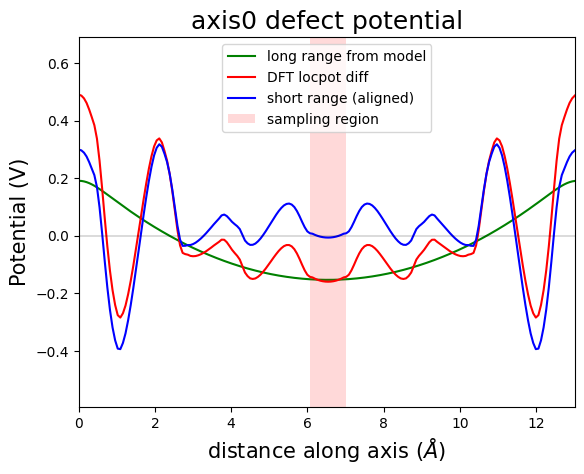

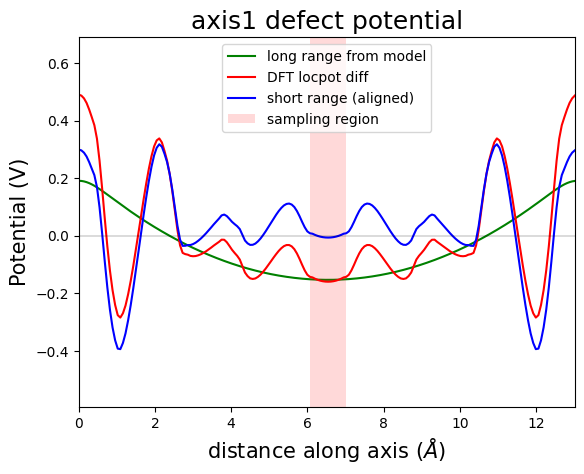

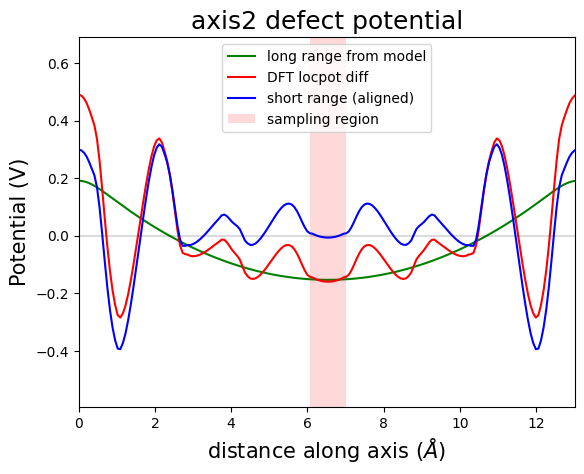

In [8]:
frey_corr = get_correction_freysoldt(parsed_vac_Cd_dict["vac_1_Cd_-2"], 9.13, plot = True)

Note that here we have used the Freysoldt (FNV) image charge correction scheme, which assumes an isotropic dielectric screening and so should only be used with **_isotropic/cubic host materials_**.
`doped` also supports the Kumagai-Oba (eFNV) charge correction scheme, which allows for anisotropic dielectric screening and so should be used for **_anisotropic/non-cubic host materials_**.

`doped` will automatically perform the appropriate charge correction method for your system, based on the supplied `dielectric` constant and calculation outputs, and will warn you if any required outputs are missing.

#### Kumagai-Oba (eFNV) Charge Correction Example:

Here we're taking the example of a Fluorine-on-Oxygen antisite substitution defect in $Y_2Ti_2O_5S_2$ (a promising photocatalyst and [_n_-type thermoelectric](https://pubs.rsc.org/en/content/articlelanding/2022/TA/D2TA04160J)), which has a non-cubic anisotropic structure and dielectric constant:

In [11]:
F_O_1_entry = analysis.defect_entry_from_paths(defect_path="YTOS/F_O_1", bulk_path="YTOS/Bulk",
                                                dielectric = [40.7, 40.7, 25.2])
print(f"Charge: {F_O_1_entry.charge} at site: {F_O_1_entry.site}")
print(f"Finite-size charge corrections: {F_O_1_entry.corrections}")

Charge: 1 at site: [11.270724   11.27072389  0.        ] F
Finite-size charge corrections: {'charge_correction': 0.08209990653805896, 'bandfilling_correction': 0.0, 'bandedgeshifting_correction': 0.0}


Above, the defect has been parsed and the anisotropic (eFNV) charge correction correctly applied, with no warnings thrown. We can directly plot the atomic site potentials which are used to compute this charge correction if we want:
(Though typically we only do this if there has been some warning or error related to the application of the defect charge correction – here we're just showing as a demonstration)

In [4]:
from doped.utils.corrections import get_correction_kumagai


Final Kumagai correction is 0.082 eV


0.08209990653805896

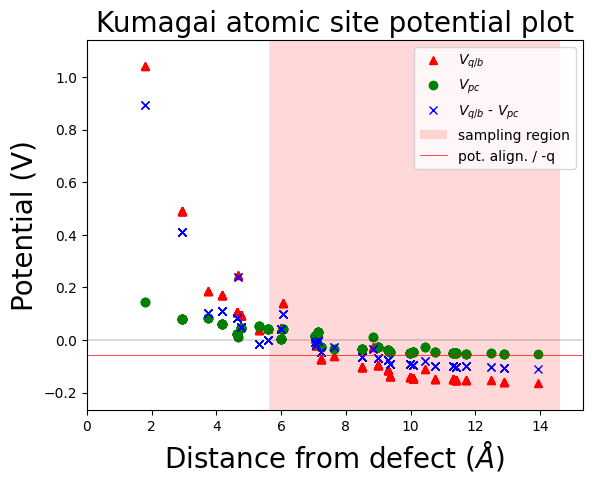

In [5]:
get_correction_kumagai(F_O_1_entry, dielectric=[40.7, 40.7, 25.2], plot=True)

## The Main Event: Formation Energy / Transition Level Diagrams

Here, we have already parsed our chemical potential calculations with `doped` (see the [`dope_chemical_potentials`](https://github.com/SMTG-UCL/doped/blob/master/examples/dope_chemical_potentials.ipynb) notebook), and saved it to file, so we reload this to use it here:

In [2]:
# load CdTe parsed chemical potentials (needed to compute the defect formation energies)
cdte_chempots = loadfn("CdTe/cdte_chempots.json")

In [3]:
print(cdte_chempots)

{'facets': {'Cd-CdTe': {'Cd': -1.01586484, 'Te': -5.7220097228125}, 'CdTe-Te': {'Cd': -2.2671822228125, 'Te': -4.47069234}}, 'elemental_refs': {'Te': -4.47069234, 'Cd': -1.01586484}, 'facets_wrt_elt_refs': {'Cd-CdTe': {'Cd': 0.0, 'Te': -1.2513173828125002}, 'CdTe-Te': {'Cd': -1.2513173828125, 'Te': 0.0}}}


Some of the advantages of parsing / manipulating your chemical potential calculations this way, is that:

- You can quickly loop through different points in chemical potential space (i.e. phase diagram facets), rather than typing out the chemical potentials obtained from a different method (e.g. from `CPLAP`).
- `doped` automatically determines the chemical potentials with respect to elemental references (i.e. chemical potentials are zero in their standard states (by definition), rather than VASP/DFT energies). This is the `facets_wrt_elt_refs` entry in the `cdte_chempots` dict in the cell above.
- `doped` can then optionally print the corresponding phase diagram facet / chemical potential limit and the _formal_ chemical potentials of the elements at that point, above the formation energy plot, as shown in the next cell.

Alternatively, you can directly feed in pre-calculated chemical potentials to `doped`, see below for this.

In [17]:
# generate DefectPhaseDiagram object, with which we can plot/tabulate formation energies, calculate charge transition levels etc:
vac_Cd_dpd = analysis.dpd_from_defect_dict(parsed_vac_Cd_dict)
dumpfn(vac_Cd_dpd, "vac_Cd_dpd.json")  # save parsed DefectPhaseDiagram to file, so we don't need to regenerate it later

Basic formation energy plot:

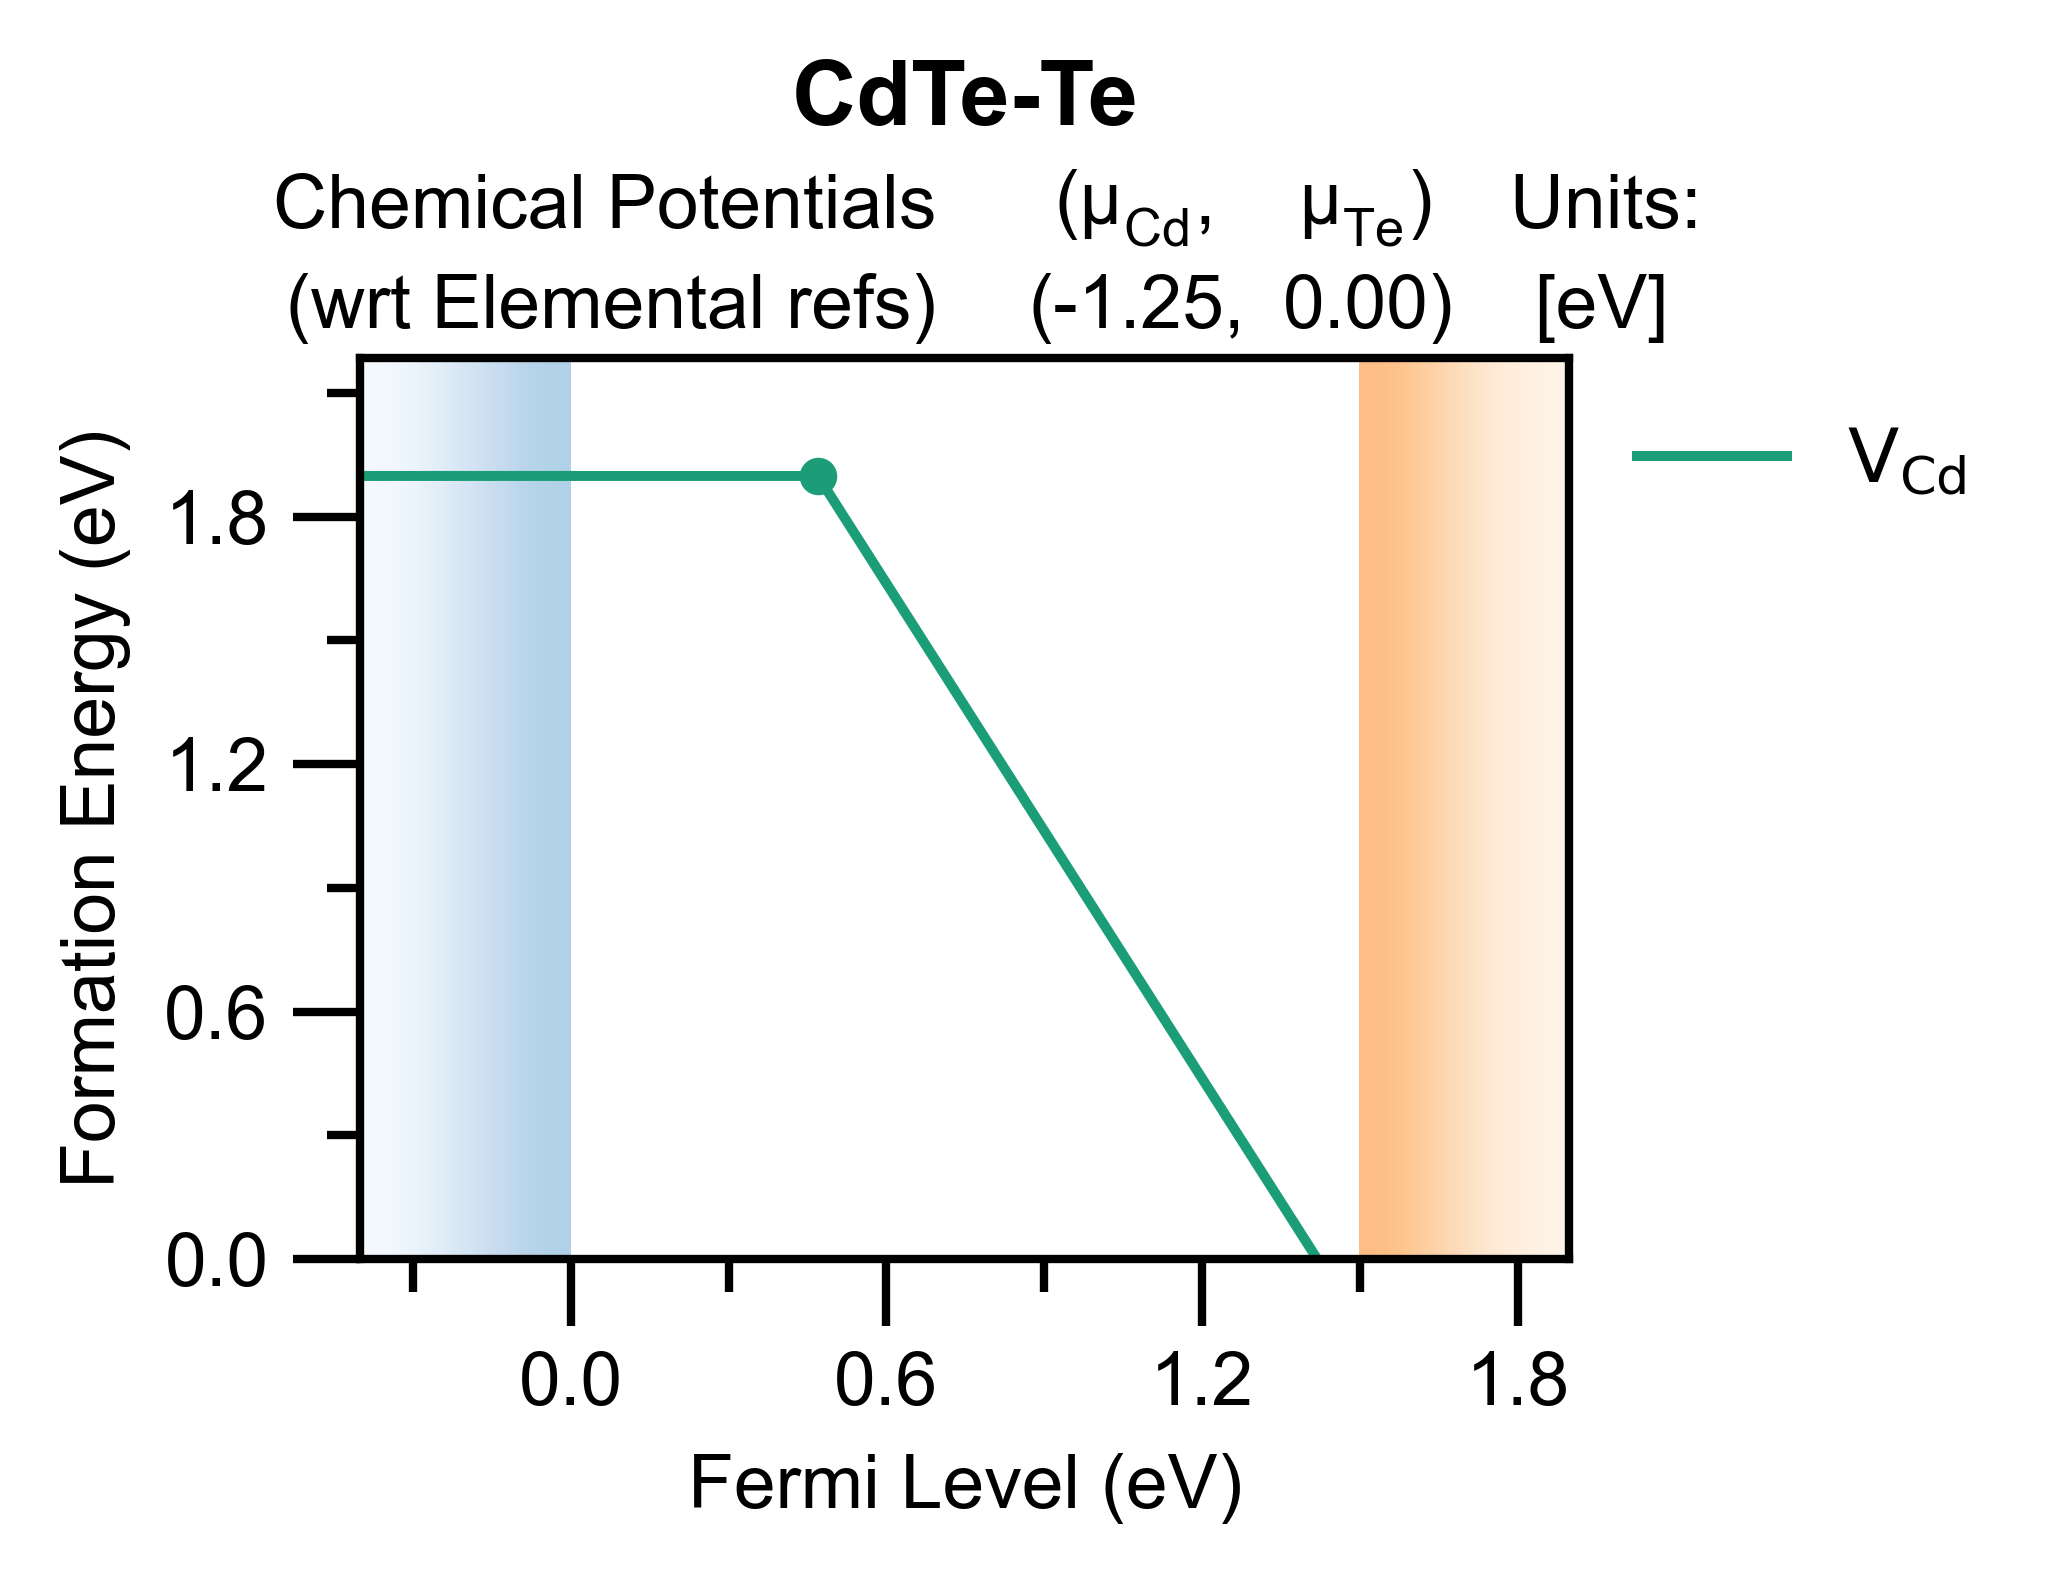

In [7]:
def_plot = plotting.formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    pd_facets=["CdTe-Te"],
)

There are a lot of options for making the formation energy plot prettier:

In [16]:
# run this cell to see the possible arguments for this function:
plotting.formation_energy_plot?

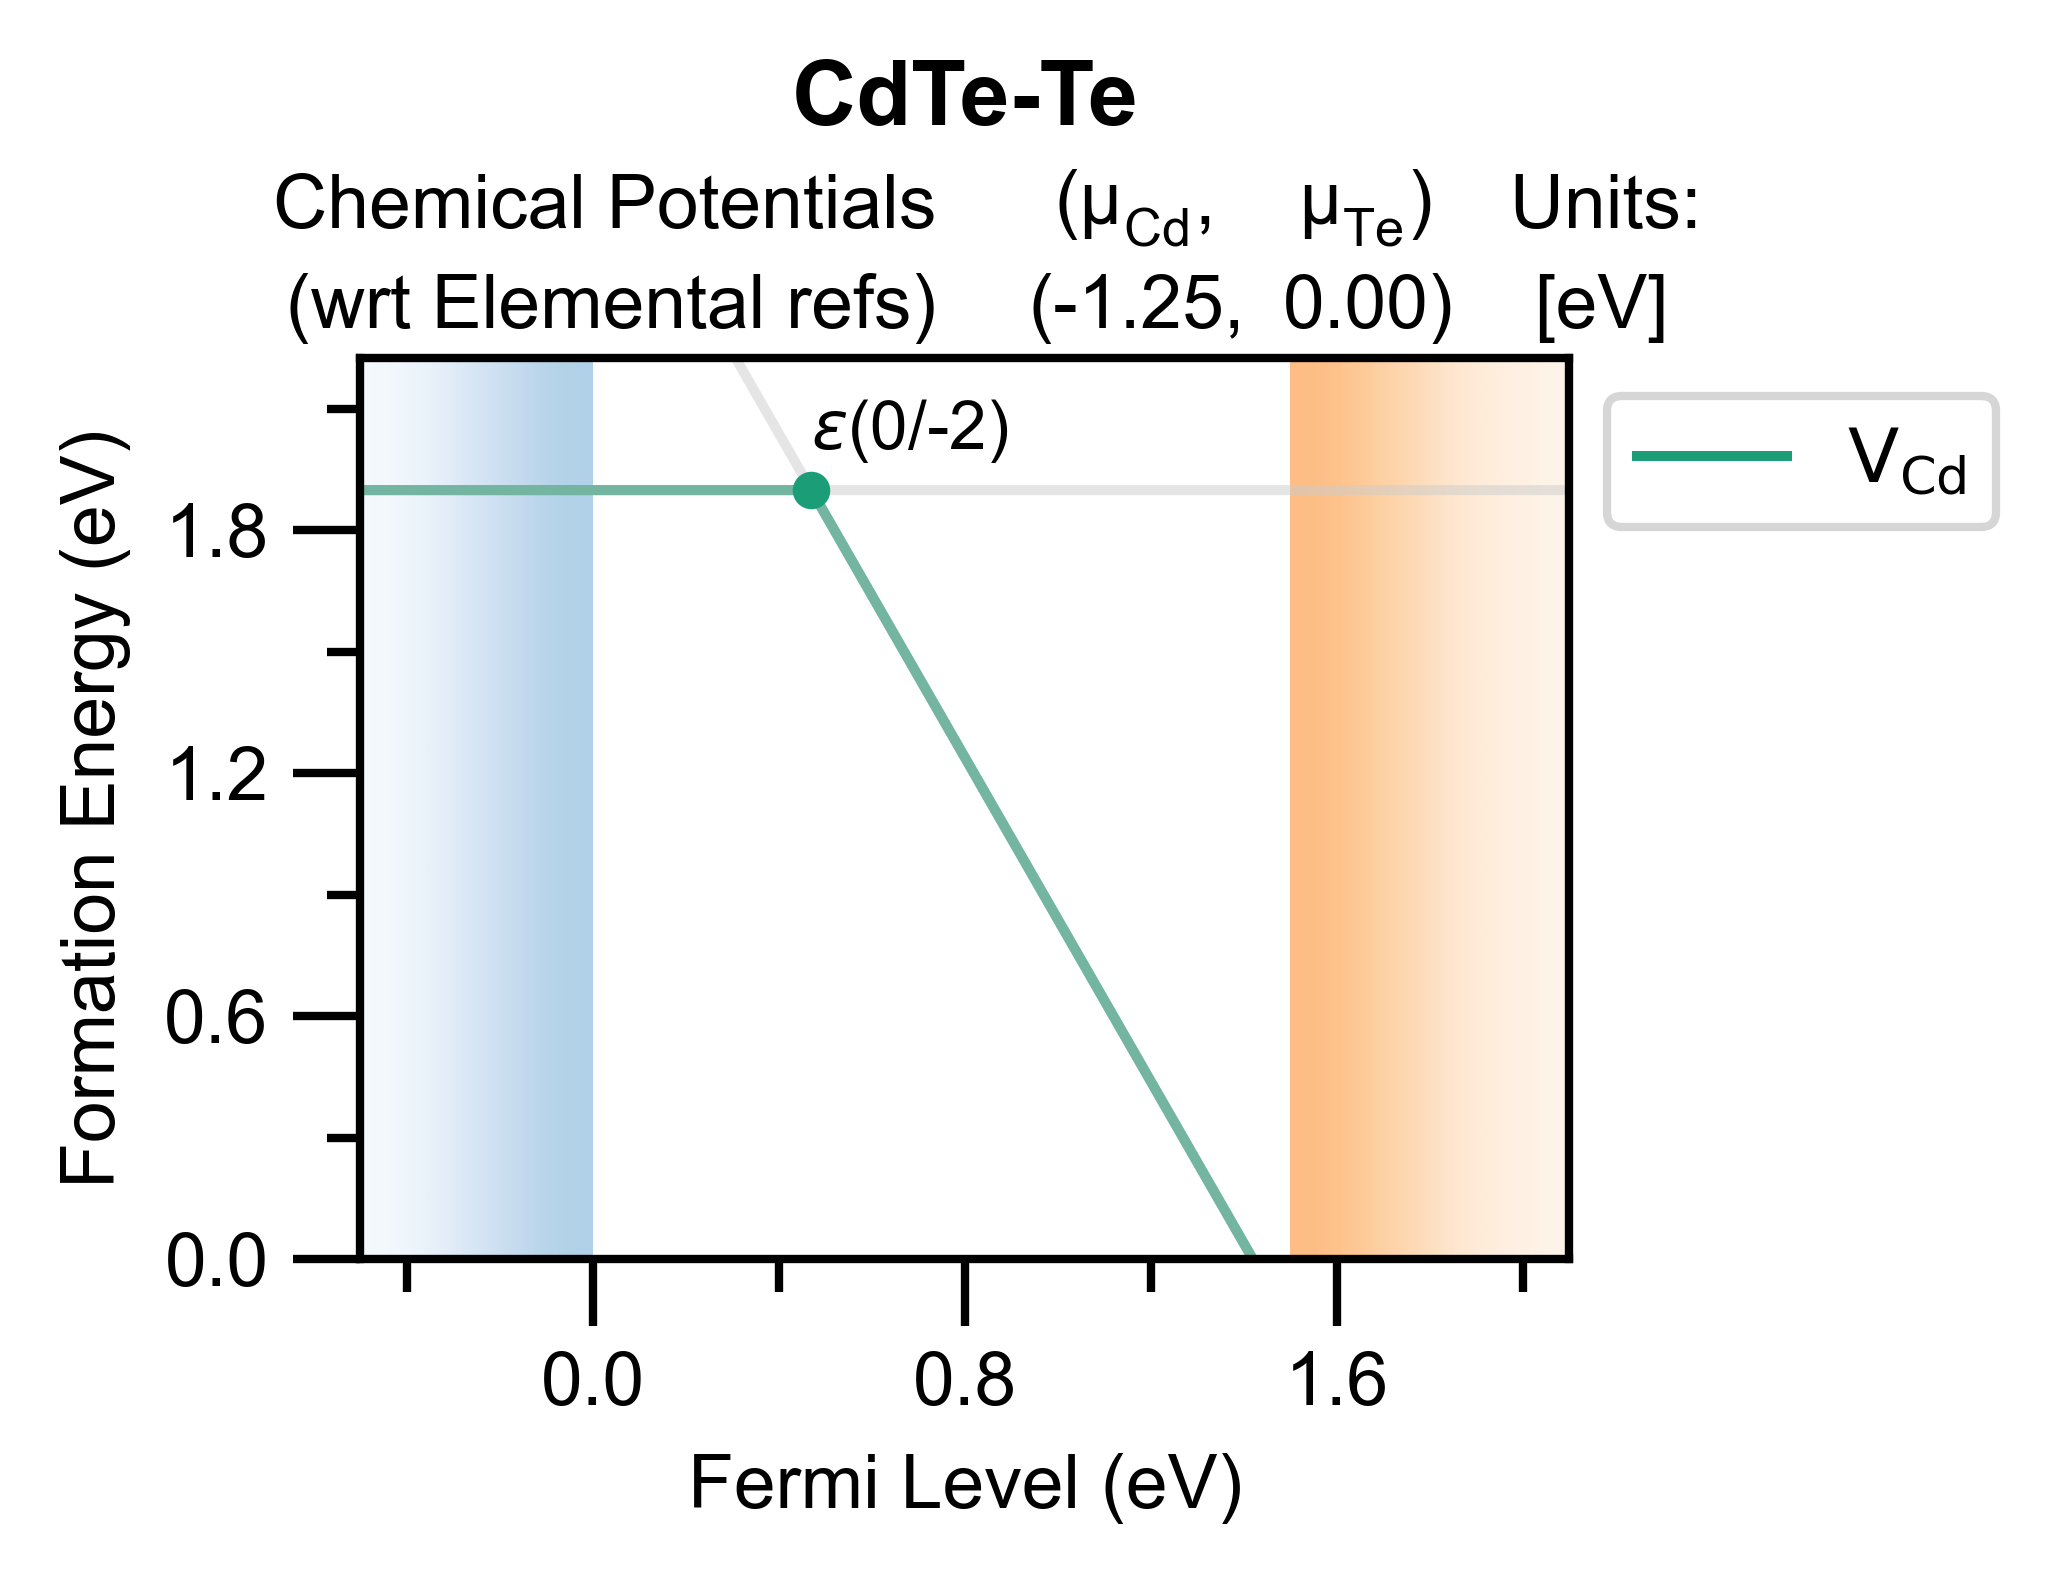

In [17]:
def_plot = plotting.formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    auto_labels=True,
    xlim=(-0.5, 2.1),
    emphasis=True,
    frameon=True,
    pd_facets=["CdTe-Te"],
    saved=True, # Save plot and give filename
    filename="V_Cd_Formation_Energy_Te-Rich.pdf"
)

`plotting.formation_energy_plot` also returns the `matplotlib` plot object, so you can customise this as much as you like!

**Manually inputting chemical potentials:**

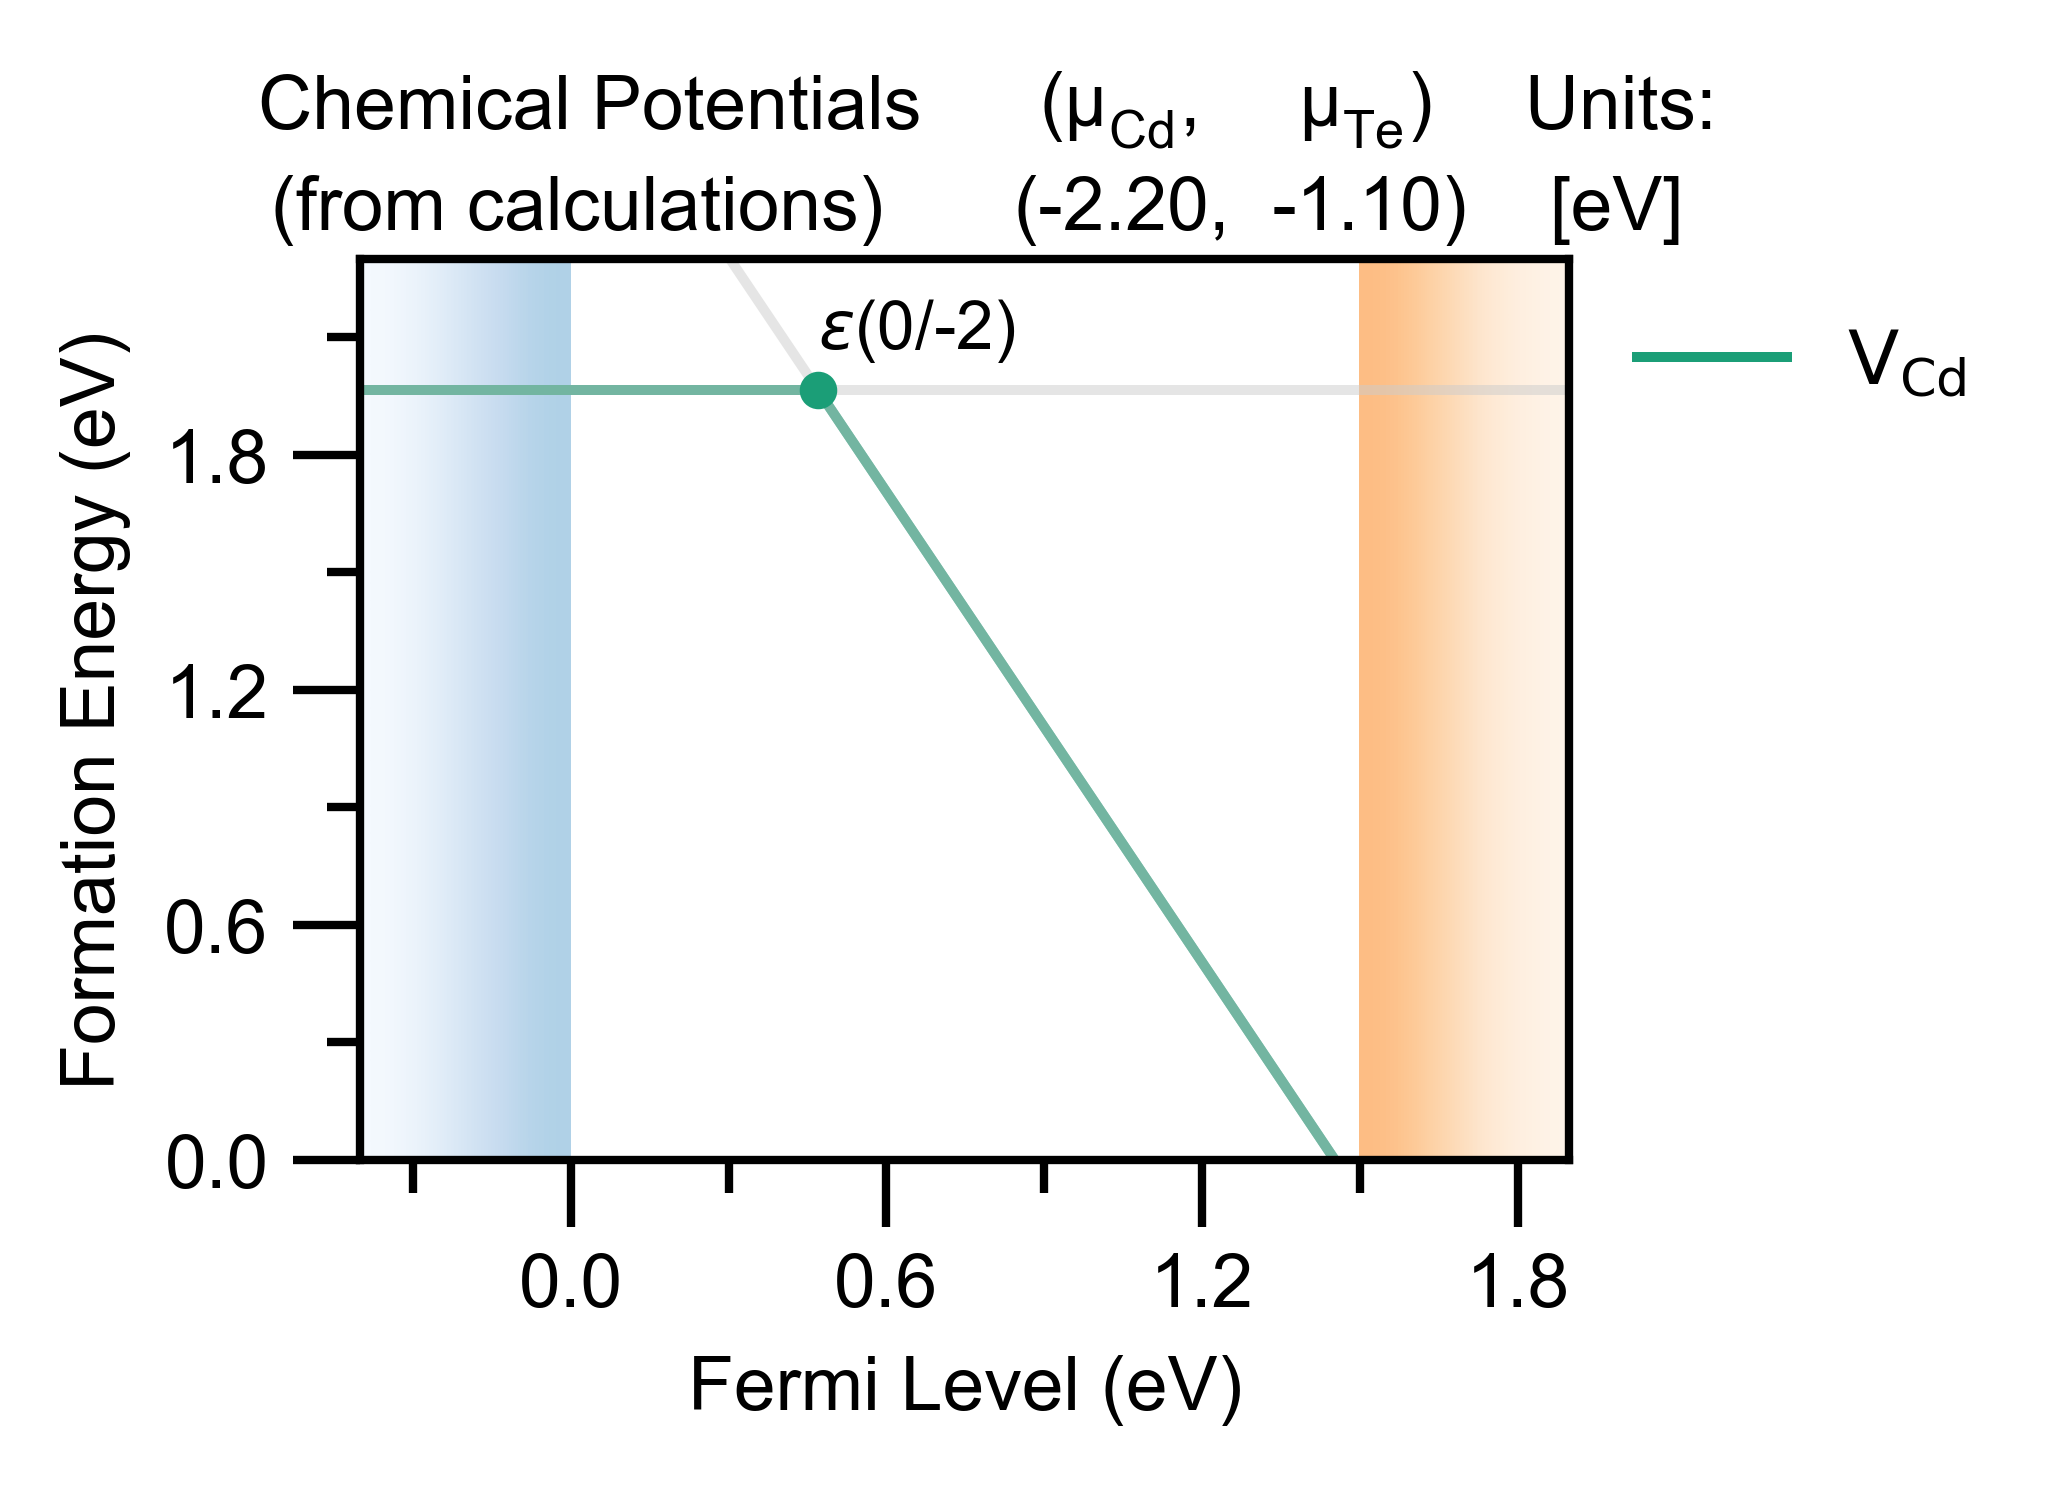

In [9]:
def_plot = plotting.formation_energy_plot(
    vac_Cd_dpd,
    chempot_limits = {"Cd": -2.2, "Te": -1.1},
    auto_labels=True,
    emphasis=True,
)

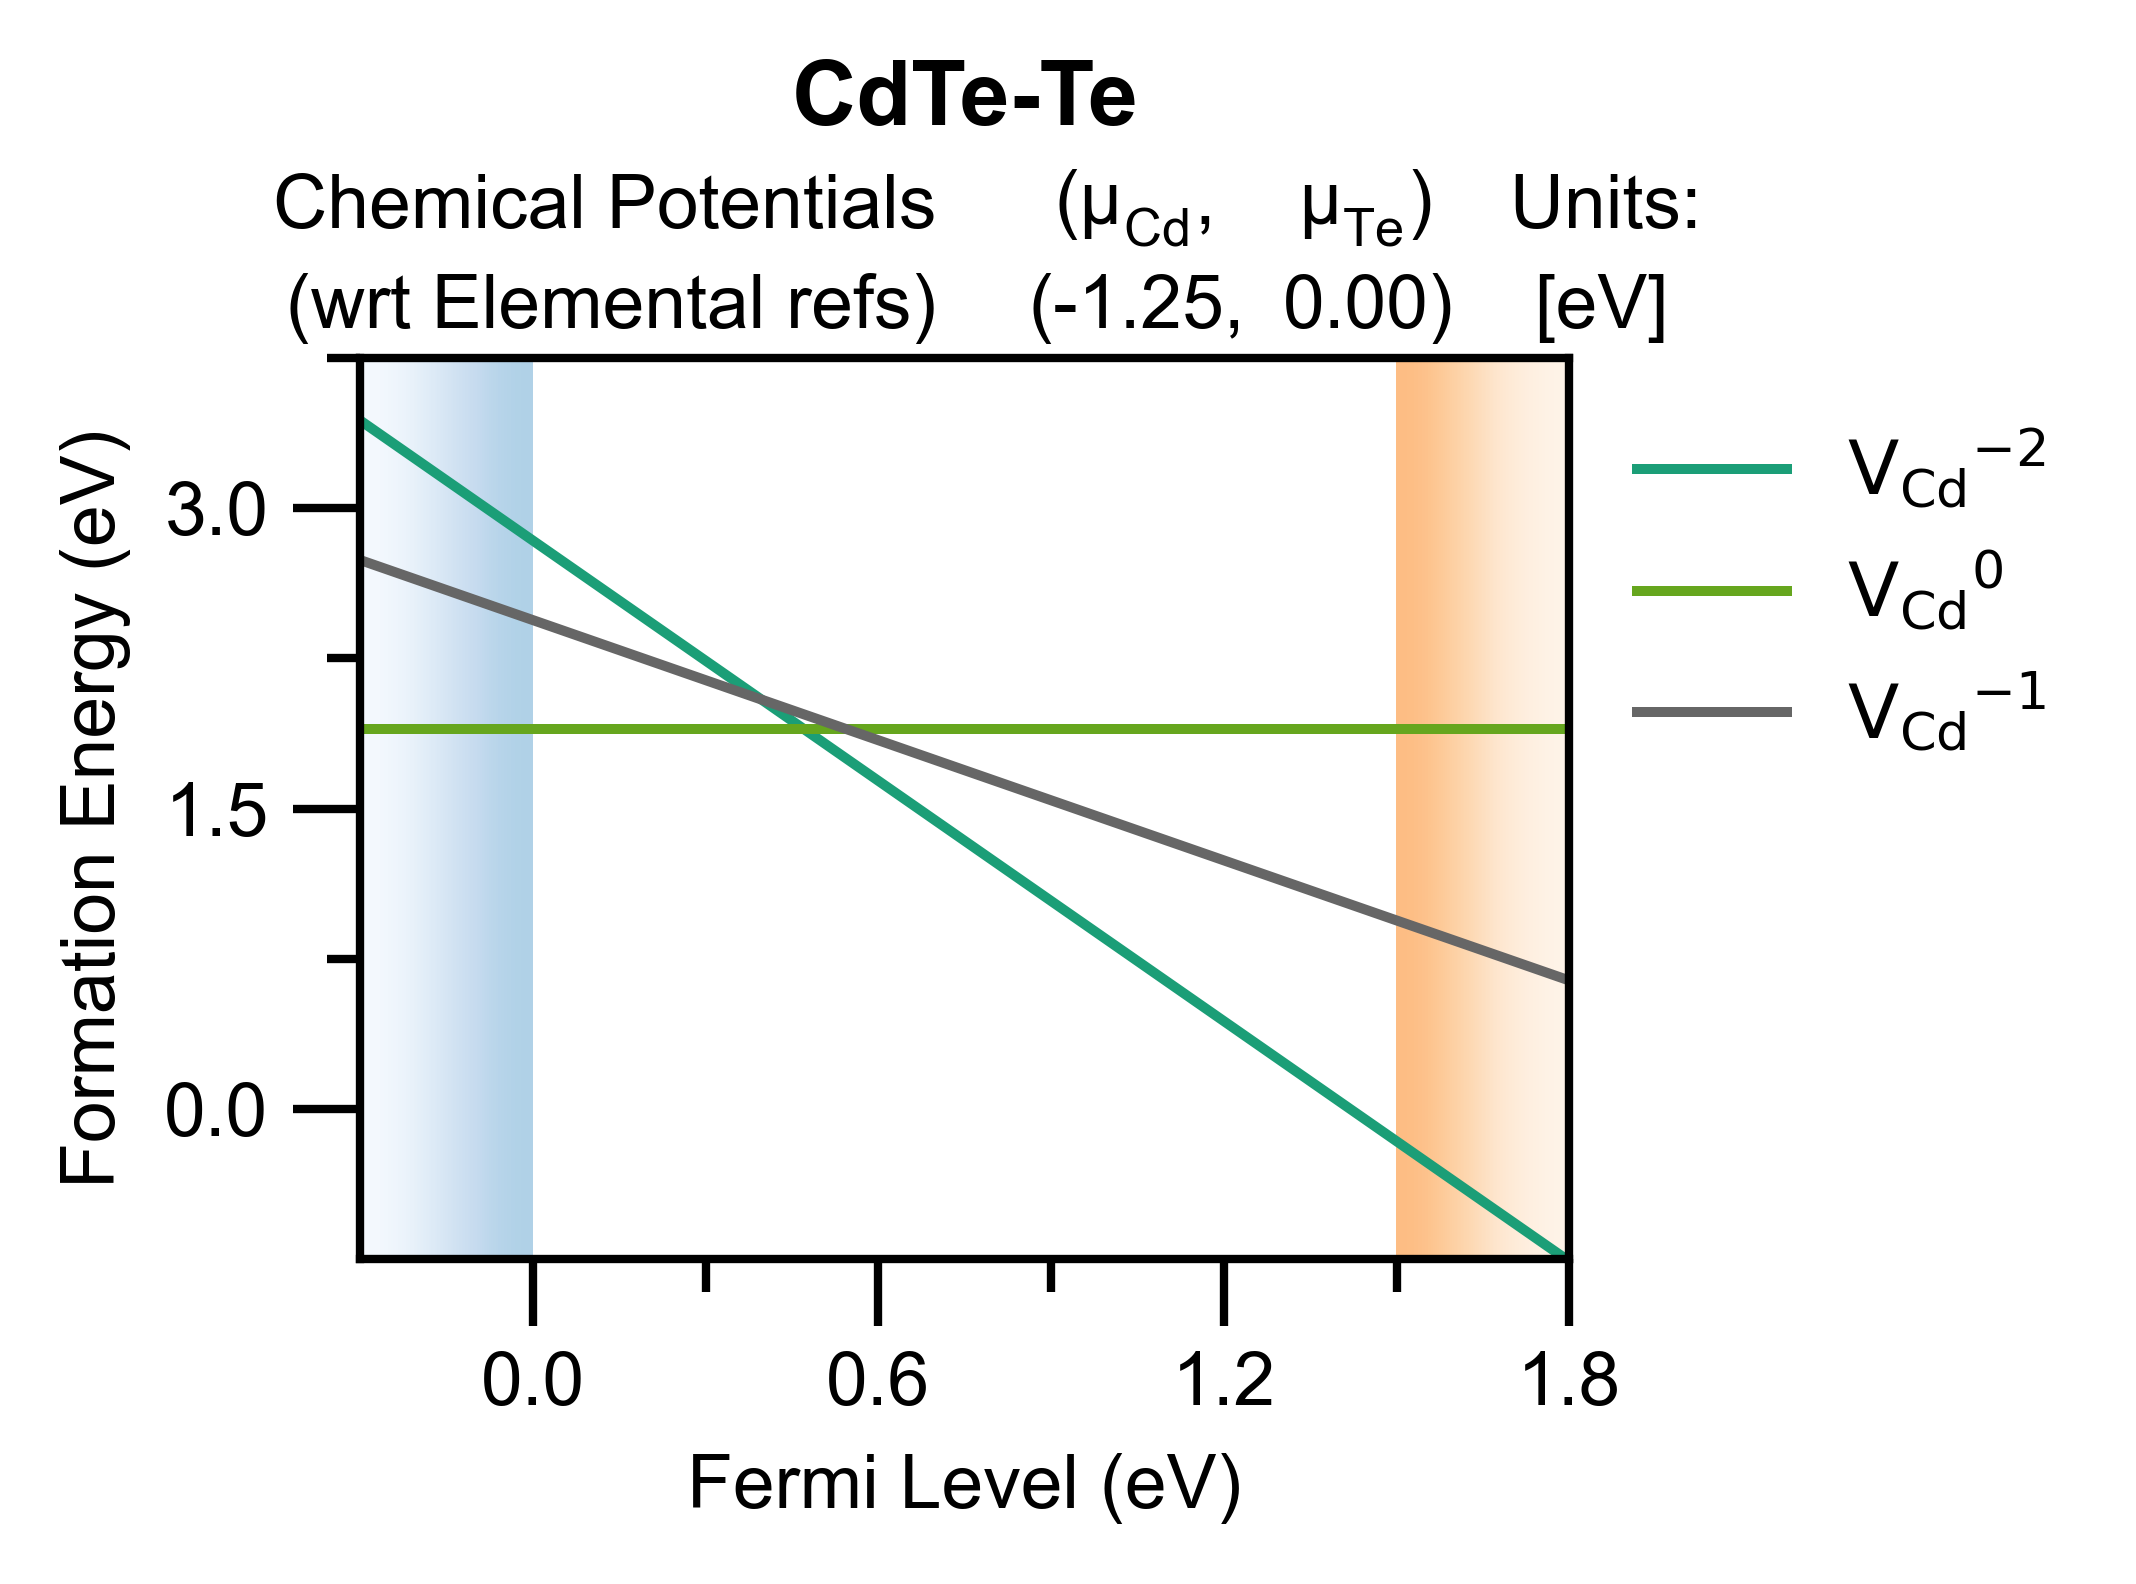

In [10]:
def_plot = plotting.all_lines_formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    auto_labels=False,
    xlim=(-0.3, 1.8),
    ylim=(-0.75,3.75),
    pd_facets=["CdTe-Te"],
    filename="V_Cd_Te-Rich_All_Lines.pdf"
)

If you have parsed all your calculated defects as above with `doped` and created the `DefectPhaseDiagram` object (e.g. `CdTe_defects_dpd` in this example), you can also plot the formation energies of all the defects together, as shown below:

In [11]:
CdTe_defects_dpd = loadfn("../local_doped_testing/parsed_CdTe_defects_dpd.json")  # not available on GitHub

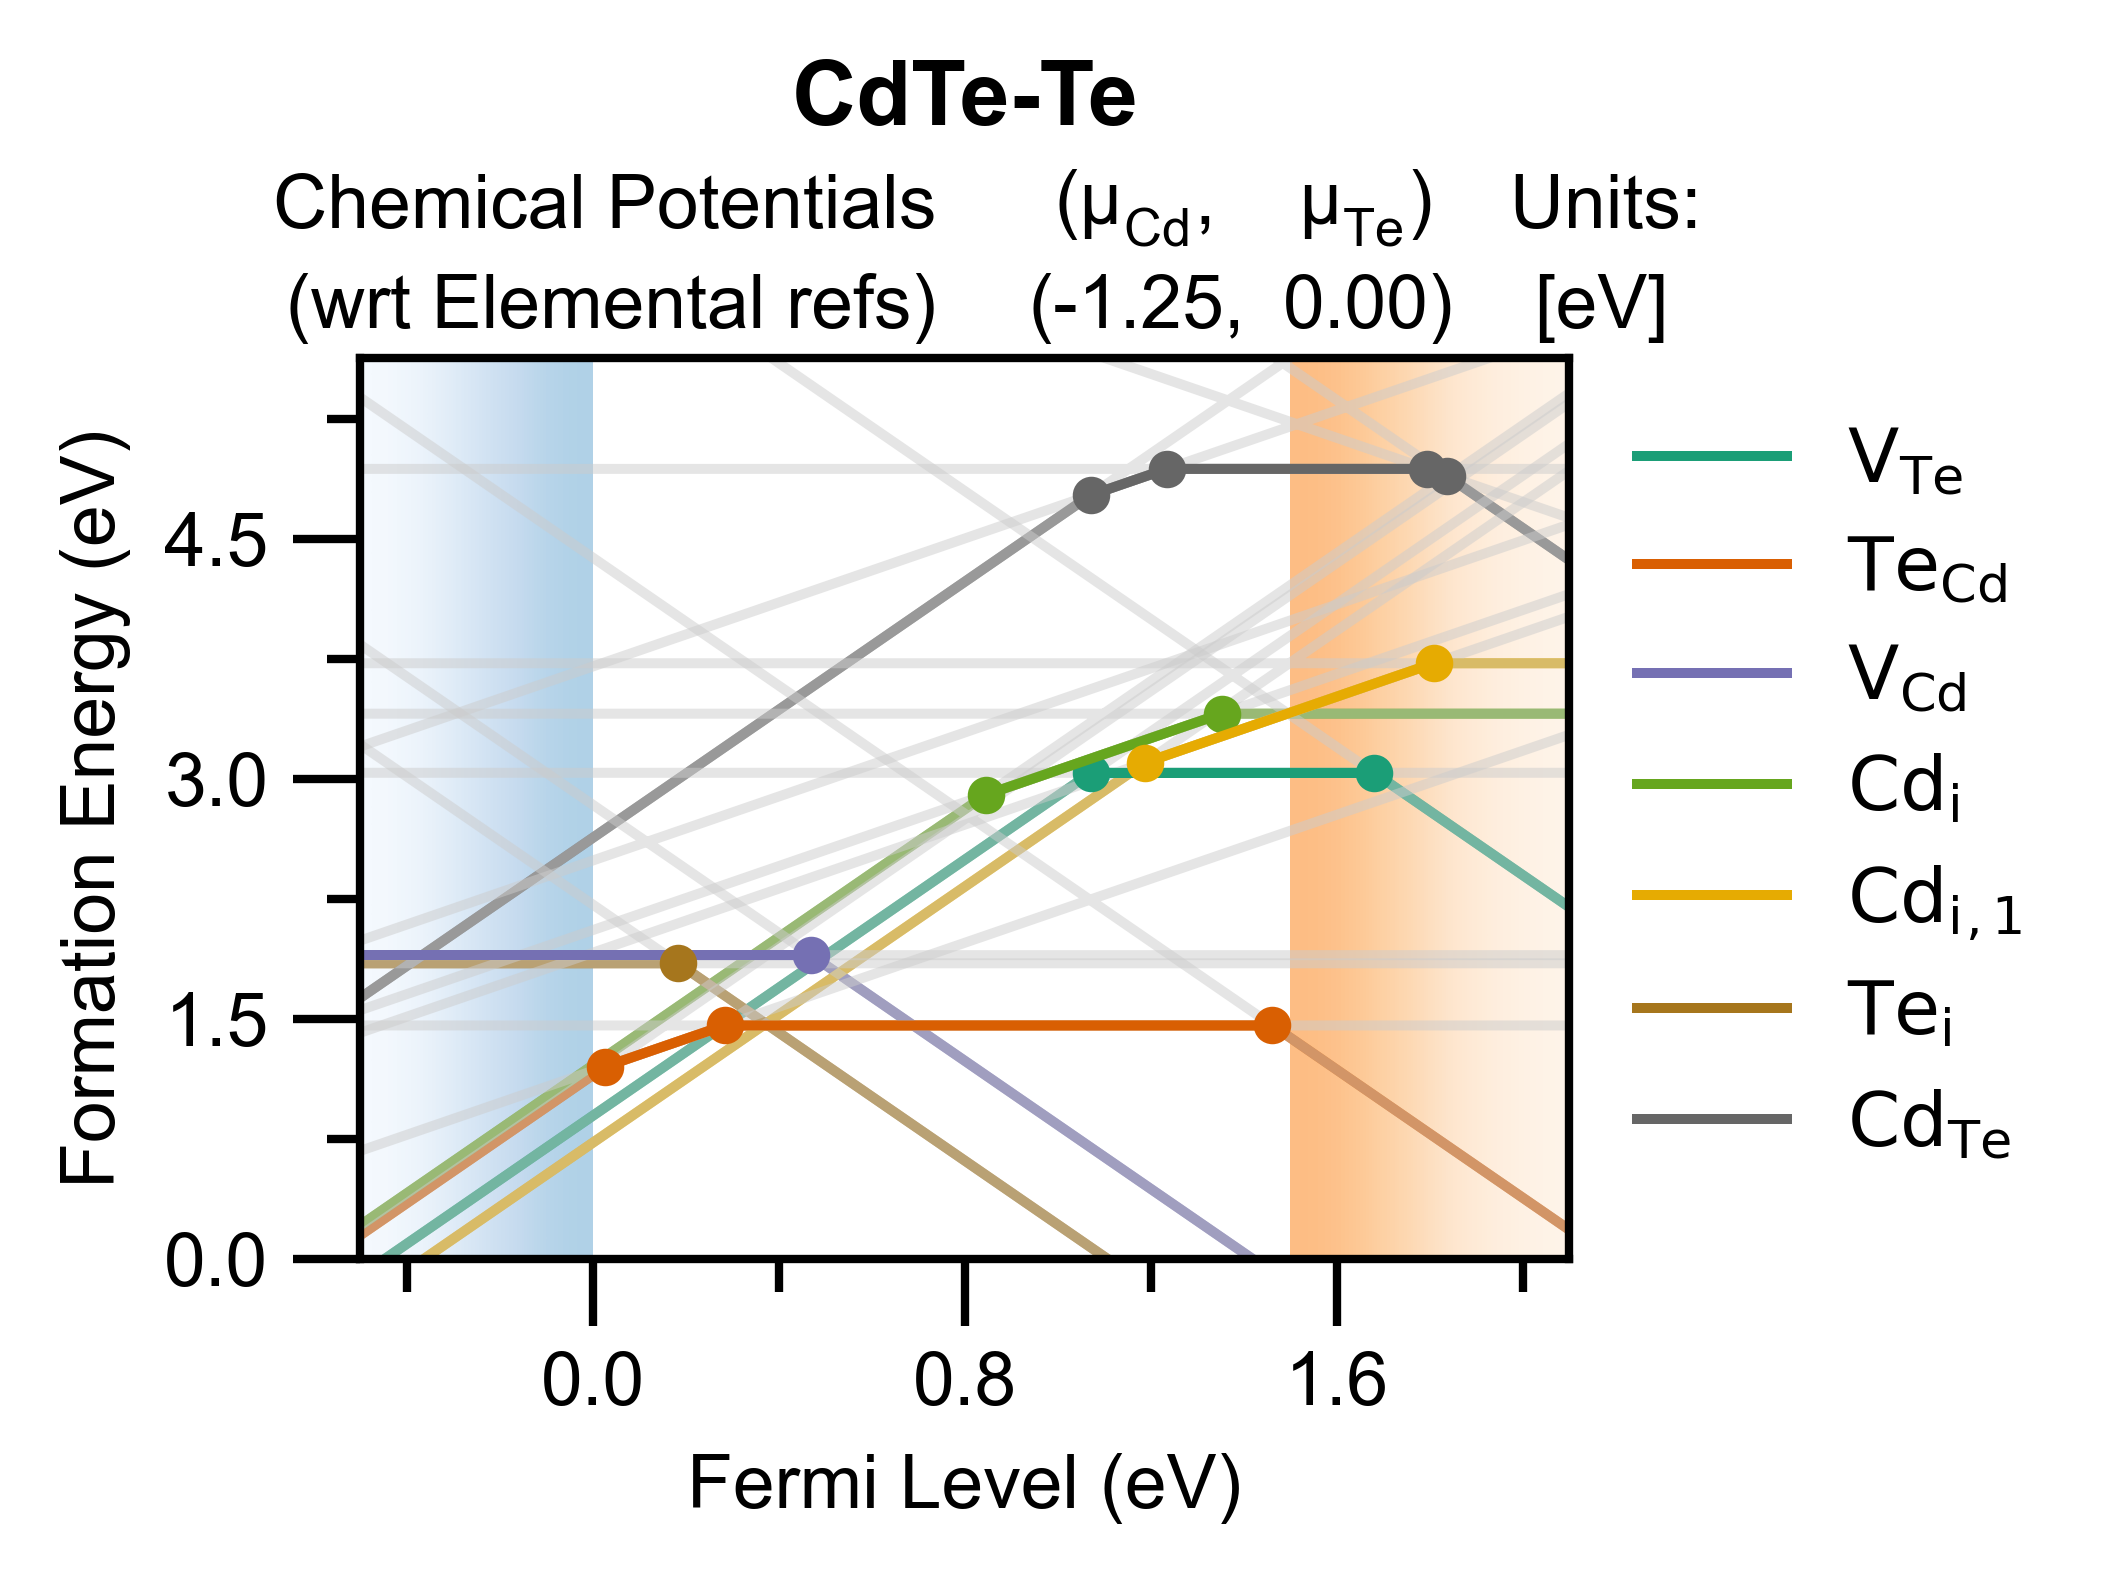

In [12]:
# Example plot of final results:
def_plot = plotting.formation_energy_plot(
    CdTe_defects_dpd,
    cdte_chempots,
    xlim=(-0.5, 2.1),
    emphasis=True,
    pd_facets=["CdTe-Te"],
)

# Defect Concentrations

Using our final parsed `DefectPhaseDiagram` object, we can now calculate the defect concentrations at different points in chemical potential space, as shown below:

In [ ]:
vac_Cd_0_sorted = sorted([defect for defect in CdTe_defects_dpd.entries if defect.name == "Vac_Cd_mult32" and defect.charge == 0], key=lambda x: x.energy)
vac_Cd_0_Te_dimer = vac_Cd_0_sorted[0]

In [ ]:
def_energy = lambda x: x.energy
def_energy(vac_Cd_0_sorted[0])

In [47]:
print(f"V_Cd^0 concentration in p-type CdTe at T=1000K: {vac_Cd_0_Te_dimer.defect_concentration(cdte_chempots['facets']['CdTe-Te'], temperature=1000, fermi_level = 0.3):.2E} cm^3")

V_Cd^0 concentration in p-type CdTe at T=1000K: 3.86E+12 cm^3


In [46]:
print(f"V_Cd^0 formation energy in p-type CdTe: {vac_Cd_0_Te_dimer.formation_energy(cdte_chempots['facets']['CdTe-Te'], fermi_level = 0.3):.3f} eV")

V_Cd^0 formation energy in p-type CdTe: 1.899 eV


In [70]:
from doped.pycdt.utils.parse_calculations import get_vasprun

In [71]:
CdTe_dos_vr, CdTe_dos_vr_path = get_vasprun("prim_cell_DOS/vasprun.xml.gz")  # not available on GitHub

In [75]:
T = 273.15 + 750 # 750 degrees C
CdTe_defects_dpd.solve_for_fermi_energy(T, cdte_chempots["facets"]["CdTe-Te"], CdTe_dos_vr.complete_dos)

0.5158090324034222

In [79]:
print(f"V_Cd^0 concentration in p-type CdTe at T=1000K: {vac_Cd_0_Te_dimer.defect_concentration(cdte_chempots['facets']['CdTe-Te'], temperature=T, fermi_level = 0.5158):.2E} cm^3")

V_Cd^0 concentration in p-type CdTe at T=1000K: 6.35E+12 cm^3


Note that for more advanced analysis of the self-consistent Fermi level and defect concentrations, it's recommended to use the excellent [`py-sc-fermi`](https://py-sc-fermi.readthedocs.io/en/latest/) package.

## Further Post-Processing and Correction Analysis

Here we describe some more targeted analysis you can do for your defect calculations (including comparing the relaxed configurations for different initial interstitial positions, structure & bond length analysis of defects, and plotting/analysis of the defect charge corrections), which may be useful for in certain cases.

### Processing Cadmium Interstitial `vasp_gam` calculations to see which coordination is favoured

In [17]:
bulk_path = "CdTe/Bulk_Supercell/vasp_gam/"  # path to bulk (defect-free) supercell calculation
dielectric = 9.13  # calculated dielectric constant, required for computing defect charge corrections
parsed_Int_Cd_Dict = {}  # Keep dictionary of parsed defect entries

for i in ["Int_Cd_1_0", "Int_Cd_2_0", "Int_Cd_3_0"]:
    parsed_Int_Cd_Dict[i] = analysis.defect_entry_from_paths(defect_path=f"CdTe/{i}/vasp_gam/", bulk_path=bulk_path,
                                        dielectric=dielectric)

for defect_name, defect_entry in parsed_Int_Cd_Dict.items():
    print(f"Name: {defect_name}; Energy: {defect_entry.energy:.3f} eV")

Name: Int_Cd_1_0; Energy: 0.592 eV
Name: Int_Cd_2_0; Energy: 0.728 eV
Name: Int_Cd_3_0; Energy: 0.728 eV


Note that the energies here do not yet account for the chemical potentials, which are included later in the post-processing workflow (as shown earlier in this notebook). However, the chemical potential energy correction is the same for each charge state or site, for a **_given defect_** (e.g. $Cd_i$ here) - hence the relative energies are still meaningful here.

`Int_Cd_2_0` and `Int_Cd_3_0` have equal final energies (rounded to 1 meV/atom) suggesting they have relaxed to the same final structure.
Let's use `StructureMatcher` and `local_env` to double-check:

In [9]:
# Run this cell to see all the data stored in the Defect_Entry object
# energy, corrections, structure & site info, dielectric, calculation info & metadata etc
parsed_Int_Cd_Dict['Int_Cd_1_0']

In [18]:
# Here we use the pymatgen StructureMatcher class to compare the relaxed structures of Int_Cd_X_0:
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher()
print("Are Int_Cd_1_0 and Int_Cd_2_0 final structures the same?:",
      sm.fit(parsed_Int_Cd_Dict['Int_Cd_1_0'].parameters['final_defect_structure'],
             parsed_Int_Cd_Dict['Int_Cd_2_0'].parameters['final_defect_structure']))
print("Are Int_Cd_2_0 and Int_Cd_3_0 final structures the same?:",
      sm.fit(parsed_Int_Cd_Dict['Int_Cd_2_0'].parameters['final_defect_structure'],
             parsed_Int_Cd_Dict['Int_Cd_3_0'].parameters['final_defect_structure']))

Are Int_Cd_1_0 and Int_Cd_2_0 final structures the same?: False
Are Int_Cd_2_0 and Int_Cd_3_0 final structures the same?: True


In [9]:
# we can perform further defect structural analysis with these functions:
from pymatgen.analysis.local_env import CrystalNN
for key, defect_entry in parsed_Int_Cd_Dict.items():
    crystalNN = CrystalNN()
    struct = defect_entry.parameters['final_defect_structure']
    isite = 32  # Starts counting from zero! This is where the interstitial is
    print("Local order parameters (i.e. resemblence to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ",
          crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct, isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ", bond_lengths, "\n")

Local order parameters (i.e. resemblence to given structural motif):  None
Nearest-neighbour dictionary:  {'Te': 6, 'Cd': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}] 

Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.08049643519922586, 'tetrahedral': 0.9999935468913711, 'rectangular see-saw-like': 0.007133072179242341, 'see-saw-like': 0.23547633536015408, 'trigonal pyramidal': 0.24644908542744104}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.911'}, {'Element':

No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.


So `Int_Cd_2_0` and `Int_Cd_3_0` have definitely relaxed to the same structure. This means we only need to continue with one of them for the more expensive `vasp_std` and `vasp_ncl` calculations.

Note that if you want to do this coordination environment analysis with a vacancy, you may have to introduce a fake atom at the vacancy position, in order to create a `pymatgen` `Site` object, to then use with `CrystalNN`.
For example:

In [36]:
from pymatgen.analysis.local_env import CrystalNN
from doped import analysis

for defect_entry in vac_Cd_dpd.entries:
    analysis.bold_print(f"{defect_entry.name}, Charge: {defect_entry.charge}")
    crystalNN = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False, search_cutoff=5)
    struct = defect_entry.parameters['final_defect_structure'].copy()
    struct.append('U', defect_entry.site.frac_coords) # Have to add a fake element
    isite = len(struct.sites) - 1 # Starts counting from zero!
    print("Local order parameters (i.e. resemblance to given structural motif): ",
          crystalNN.get_local_order_parameters(struct,isite))
    print("Nearest-neighbour dictionary: ", crystalNN.get_cn_dict(struct,isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct,isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ",bond_lengths,"\n")

Vac_Cd_mult32, Charge: -2
Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.07996848894580866, 'tetrahedral': 0.999999999996243, 'rectangular see-saw-like': 0.007024644113827354, 'see-saw-like': 0.23425369905750856, 'trigonal pyramidal': 0.24520967518806777}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}] 

Vac_Cd_mult32, Charge: 0
Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.08150258713827398, 'tetrahedral': 0.9998679826557854, 'rectangular see-saw-like': 0.007314581470890161, 'see-saw-like': 0.23430515920411413, 'trigonal pyramidal': 0.24525978735323237}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.610'}, {'Elemen